# DD_LSROM
Notebook to implement and test DD LS-ROM on time-dependent 2D Burgers' equation.  
Author: Alejandro Diaz  
Date:  1/14/2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.sparse as sp
import scipy.linalg as la
from time import time
from utils.Burgers2D_probgen import Burgers2D
from utils.helpers import sp_diag
from utils.domain_decomposition import subdomain_indices, state_component, DD_FOM, DDFOM_data
from utils.lsrom import compute_bases_from_svd, DD_LSROM, assemble_snapshot_matrix
from IPython.display import HTML, Image
from utils.solvers import newton_solve
import sys, os
import dill as pickle

In [2]:
plt.rc('font', size=20)
plt.rcParams['text.usetex'] = True

In [3]:
# make directories for figures and data
data_dir = './data/'
fig_dir0 = './figures/'
for d in [data_dir, fig_dir0]:
    if not os.path.exists(d): os.mkdir(d)

## Set FOM parameters, initial condition

In [4]:
# parameters for physical domain and FD discretization
x_lim = [0, 1]
y_lim = [0, 1]
nx, ny    = 60, 60
viscosity = 1e-2

In [5]:
# parameterized initial conditions
def u0(XY, mu):
    val = np.zeros(len(XY))
    for i, xy in enumerate(XY):
        if np.all([xy[0] >= 0.0, xy[0] <= 0.5, xy[1] >= 0.0, xy[1] <= 0.5]):
            val[i] = mu*np.sin(2*np.pi*xy[0])*np.sin(2*np.pi*xy[1])
    return val 

def v0(XY, mu):
    val = np.zeros(len(XY))
    for i, xy in enumerate(XY):
        if np.all([xy[0] >= 0.0, xy[0] <= 0.5, xy[1] >= 0.0, xy[1] <= 0.5]):
            val[i] = mu*np.sin(2*np.pi*xy[0])*np.sin(2*np.pi*xy[1])
    return val 

In [6]:
# time integration parameters
nt    = 1000
t_lim = [0, 2]

# parameter for initial condition
mu = 1.0

scaling = -1

## Initialize monolithic FOM and DD FOM

In [7]:
# initialize model
print('Initializing Burgers model...')
sys.stdout.flush()
fom = Burgers2D(nx, ny, x_lim, y_lim, viscosity)
print('Done!')

Initializing Burgers model...
Done!


In [8]:
# number of subdomains in x and y directions
nsub_x, nsub_y = 2, 1

# initialize DD FOM
ddfom = DD_FOM(fom, nsub_x, nsub_y, scaling=scaling)
ddfom.set_initial(lambda xy: u0(xy, mu), lambda xy: v0(xy, mu))

## Load FOM solution

In [9]:
ddfom_data = DDFOM_data(nx, ny, nt, viscosity, mu, nsub_x, nsub_y, data_dir)
ddfom_data.assemble_full_solution(ddfom)

## Build DD LS-ROM

In [10]:
# energy criteria for interior and interface bases
ec_res  = 1e-16
ec_intr = 1e-5
ec_intf = 1e-5

# interior and interface basis size. set to -1 to use energy criterion
nbasis_res  = -1
nbasis_intr = 10
nbasis_intf = 8

full_sub = False

In [11]:
# compute bases
res_bases, intr_bases, intf_bases = [], [], []
data_dir2 = data_dir + f'nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/DD_{nsub_x}x_by_{nsub_y}y/' 
fs_str = 'full_subdomain_' if full_sub else ''
for i in range(ddfom.n_sub):
    sub_dir  = data_dir2 + f'sub_{i+1}of{ddfom.n_sub}/'
    intr_dir = sub_dir + 'interior/'
    intf_dir = sub_dir + 'interface/'
    
    res_dict  = pickle.load(open(sub_dir  + f'residual_svd_data.p', 'rb'))
    intr_dict = pickle.load(open(intr_dir + f'{fs_str}svd_data.p', 'rb'))
    intf_dict = pickle.load(open(intf_dir + f'{fs_str}svd_data.p', 'rb'))
    
    res_bases.append(compute_bases_from_svd(res_dict, ec=ec_res, nbasis=nbasis_res))
    intr_bases.append(compute_bases_from_svd(intr_dict, ec=ec_intr, nbasis=nbasis_intr))
    intf_bases.append(compute_bases_from_svd(intf_dict, ec=ec_intf, nbasis=nbasis_intf)) 
    
    print(f'Subdomain {i}:')
    print(f'residual_basis.shape  = {res_bases[i].shape}')
    print(f'interior_basis.shape  = {intr_bases[i].shape}')
    print(f'interface_basis.shape = {intf_bases[i].shape}\n')        

Subdomain 0:
residual_basis.shape  = (3600, 128)
interior_basis.shape  = (3480, 10)
interface_basis.shape = (240, 8)

Subdomain 1:
residual_basis.shape  = (3600, 131)
interior_basis.shape  = (3480, 10)
interface_basis.shape = (240, 8)



In [12]:
# load port bases
ec_port = 1e-5
nbasis_port = 8

port_bases = []
n_ports = len(ddfom.ports)
for j in range(len(ddfom.ports)):
    port_file = data_dir2 + f'port_{j+1}of{n_ports}_svd_data.p'
    port_dict  = pickle.load(open(port_file, 'rb'))
    port_bases.append(compute_bases_from_svd(port_dict, ec=ec_port, nbasis=nbasis_port)) 
    print(f'port_basis[{j}].shape  = {port_bases[j].shape}')

port_basis[0].shape  = (240, 8)


In [13]:
# LS-ROM parameters
hr              = True       # set to True to employ hyper reduction
n_constraints   = 1          # number of constraints when using wfpc formulation
sample_ratio    = 2          # ratio of HR nodes to residual basis size
n_samples       = -1         # number of HR nodes to use. -1 uses sample_ratio
constraint_type = 'srpc'     # 'srpc' (strong rom-port constraints) or 'wfpc' (weak fom-port constraints)

# instatiate DD LS-ROM
ddlsrom = DD_LSROM(ddfom, 
                   intr_bases,
                   intf_bases,
                   res_bases=res_bases,
                   port_bases=port_bases,
                   constraint_type=constraint_type,
                   hr=hr,
                   sample_ratio=sample_ratio,
                   n_samples=n_samples,
                   n_corners=-1,
                   n_constraints=n_constraints, 
                   seed=0, 
                   scaling=scaling)
ddlsrom.set_initial(lambda xy: u0(xy, mu), lambda xy: v0(xy, mu))

interface_basis[0].shape=(240, 8)
interface_basis[1].shape=(240, 8)


In [14]:
# POD reconstruction error
for i, s in enumerate(ddlsrom.subdomain):
    print(f'Subdomain {i}:')
    uv_intr = np.hstack([ddfom_data.subdomain[i].interior.u, ddfom_data.subdomain[i].interior.v])
    uv_intf = np.hstack([ddfom_data.subdomain[i].interface.u, ddfom_data.subdomain[i].interface.v])
    
    e_intr = np.max(np.sum(np.square(uv_intr@s.interior.basis@s.interior.basis.T-uv_intr), 1))
    e_intf = np.max(np.sum(np.square(uv_intf@s.interface.basis@s.interface.basis.T-uv_intf), 1))
    
    print(f' Interior recon. error = {e_intr}')
    print(f'Interface recon. error = {e_intf}\n')    

Subdomain 0:
 Interior recon. error = 0.02748618227262281
Interface recon. error = 0.010951750113570961

Subdomain 1:
 Interior recon. error = 0.003826074209267556
Interface recon. error = 0.010951750113570961



In [15]:
# solve DD LS-ROM
march = nt
# w_intr, w_intf, urom_intr, vrom_intr, urom_intf, vrom_intf, u_full, v_full, lam, romtime, flag \
# = ddlsrom.solve(t_lim, nt, tol=1e-4, maxit=15, print_hist=True)
w_intr, w_intf, urom_intr, vrom_intr, urom_intf, vrom_intf, u_full, v_full, lam, romtime, ih, flag \
= ddlsrom.solve([0, 2/nt*march], march, tol=1e-9, maxit=15, print_hist=False)

In [16]:
# Compute error
ntr = u_full.shape[0]
abserr = np.zeros(ntr)
for i, s in enumerate(ddlsrom.subdomain):
    abserr += np.sum(np.square(ddfom_data.subdomain[i].interior.u[:ntr]-urom_intr[i]), 1) + \
              np.sum(np.square(ddfom_data.subdomain[i].interior.v[:ntr]-vrom_intr[i]), 1) + \
              np.sum(np.square(ddfom_data.subdomain[i].interface.u[:ntr]-urom_intf[i]), 1) + \
              np.sum(np.square(ddfom_data.subdomain[i].interface.v[:ntr]-vrom_intf[i]), 1)

abserr = np.max(np.sqrt(ddfom.hx*ddfom.hy*abserr/ddfom.n_sub))
hr_str = '-HR' if hr else ''
print(f'DD LS-ROM{hr_str} absolute error = {abserr:1.4e}')

print(f'FOM runtime = {ddfom_data.runtime:1.5e} seconds')
print(f'ROM runtime = {romtime:1.5e} seconds')
print(f'Speedup     = {ddfom_data.runtime*march/nt/romtime}')

DD LS-ROM-HR absolute error = 2.5762e-03
FOM runtime = 6.01836e+02 seconds
ROM runtime = 1.36782e+01 seconds
Speedup     = 43.999613791658994


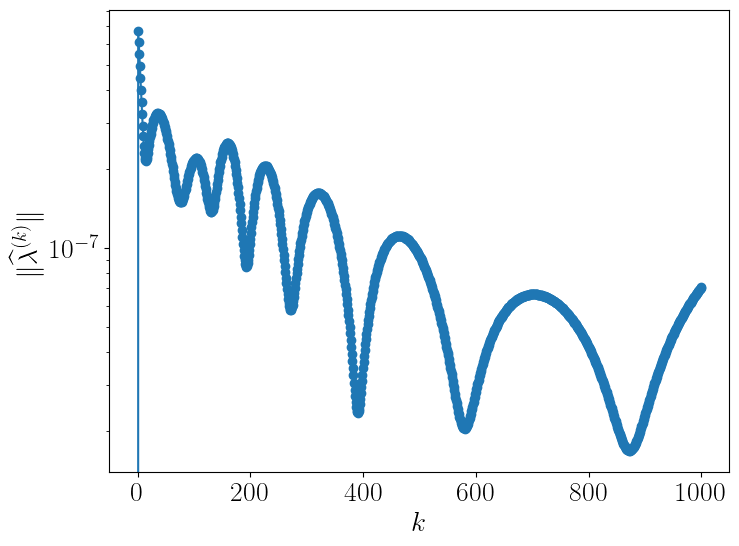

In [18]:
lt = np.array([np.linalg.norm(l) for l in lam])
plt.figure(figsize=(8,6))
plt.semilogy(lt, 'o-')
plt.xlabel('$k$')
plt.ylabel('$\|\widehat{\mathbf{\lambda}}^{(k)}\|$')
plt.show()

## Computed residuals of encoded exact solution 

In [24]:
ht = (t_lim[1]-t_lim[0])/nt
lam = np.ones(ddlsrom.n_constraints)
residuals = np.zeros((ddfom.n_sub, nt+1))
constraints = np.zeros((nt+1, ddlsrom.n_constraints))
for i, s in enumerate(ddlsrom.subdomain):
    uv_intr = np.hstack([ddfom_data.subdomain[i].interior.u,
                         ddfom_data.subdomain[i].interior.v])
    uv_intf = np.hstack([ddfom_data.subdomain[i].interface.u,
                         ddfom_data.subdomain[i].interface.v])
    w_intr = uv_intr@s.interior.basis
    w_intf = uv_intf@s.interface.basis
    
    for k in range(nt):
        res, jac, H, rhs, Ag = s.res_jac(w_intr[k+1], w_intf[k+1], w_intr[k], w_intf[k], lam, ht)
        residuals[i, k] = np.sum(np.square(res))
        constraints[k] += Ag

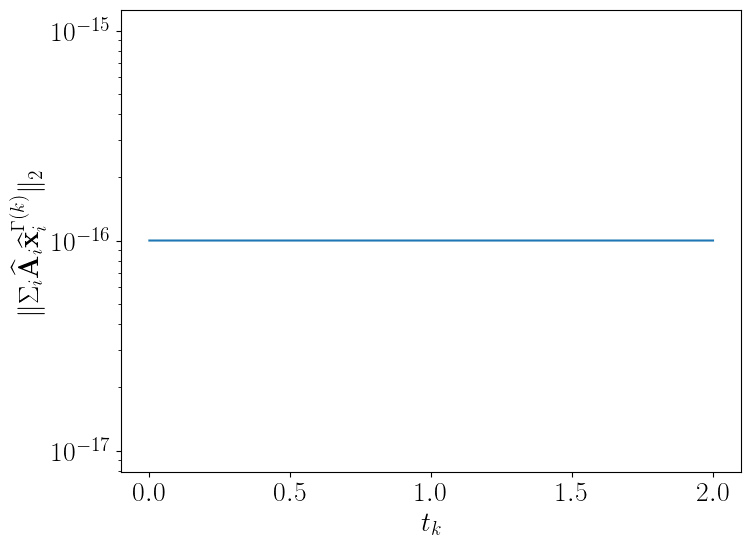

In [54]:
tt=np.linspace(t_lim[0], t_lim[1], nt+1)
con_norm = np.sqrt(np.sum(np.square(constraints), 1))
plt.figure(figsize=(8,6))
plt.semilogy(tt,con_norm+1e-16)
plt.xlabel('$t_k$')
plt.ylabel('$\|\Sigma_i \widehat{\mathbf{A}}_i \widehat{\mathbf{x}}_i^{\Gamma(k)}\|_2$')
plt.show()

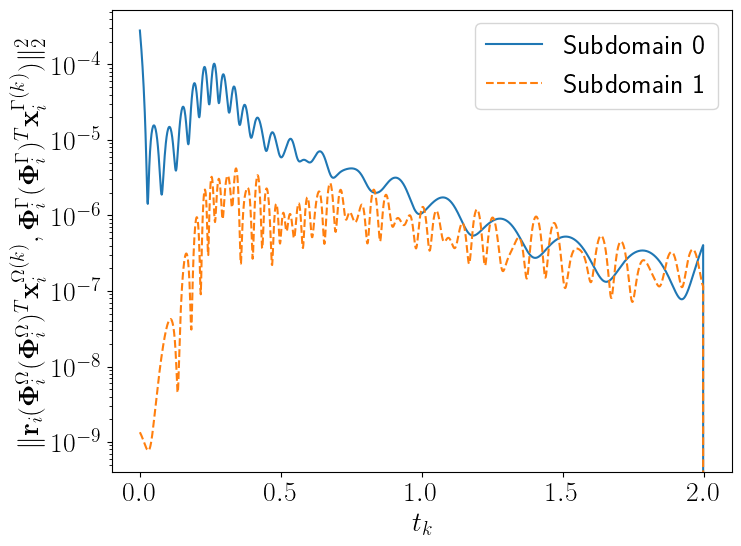

In [55]:
plt.figure(figsize=(8,6))
ls = ['-', '--', '.-', ':']
for i in range(ddlsrom.n_sub):
    plt.semilogy(tt, residuals[i], ls[i], label=f'Subdomain {i}')
plt.xlabel('$t_k$')
plt.ylabel('$\|\mathbf{r}_i(\mathbf{\Phi}_i^\Omega(\mathbf{\Phi}_i^\Omega)^T\mathbf{x}_i^{\Omega(k)}, \mathbf{\Phi}_i^\Gamma(\mathbf{\Phi}_i^\Gamma)^T\mathbf{x}_i^{\Gamma (k)})\|_2^2$')
plt.legend()
plt.show()

## Save solution, gifs of solution

In [ ]:
# store snapshots
con_dir = 'srpc/' if constraint_type == 'srpc' else f'wfpc_ncon_{n_constraints}'
intr_str = f'ecintr_{ec_intr:1.0e}_' if nbasis_intr < 0 else f'intr_{nbasis_intr}_'
if constraint_type == 'srpc':
    intf_str = f'ecport_{ec_port:1.0e}_' if nbasis_port < 0 else f'port_{nbasis_port}_'
else:
    intf_str = f'ecintf_{ec_intf:1.0e}_' if nbasis_intf < 0 else f'intf_{nbasis_intf}_'
if hr:
    hr_str = f'hr_{n_samples}_' if n_samples > 0 else f'hr_{sample_ratio}x_'
else:
    hr_str = ''
    
print('\nSaving data...')
for i, s in enumerate(ddlsrom.subdomain):
    hr_str = f'hr_{s.hr_nodes.size}_' if hr else ''
    sub_dir  = data_dir2 + f'sub_{i+1}of{ddlsrom.n_sub}/'
    intr_dir = sub_dir + 'interior/' + con_dir
    intf_dir = sub_dir + 'interface/' + con_dir
    for d in [intr_dir, intf_dir]:
        if not os.path.exists(d): os.mkdir(d)
            
    intr_dict = {'solution': w_intr[i],
                 'basis':    s.interior.basis,
                 'runtime':  romtime}
    intf_dict = {'solution': w_intf[i],
                 'basis':    s.interface.basis,
                 'runtime':  romtime}

    intr_filename = intr_dir + f'lsrom_{intr_str}{hr_str}mu_{mu}_state.p'
    intf_filename = intf_dir + f'lsrom_{intf_str}{hr_str}mu_{mu}_state.p'

    pickle.dump(intr_dict, open(intr_filename, 'wb'))
    pickle.dump(intf_dict, open(intf_filename, 'wb'))
print('Done!')    

In [ ]:
# frame updater for animation
X, Y = np.meshgrid(fom.xx, fom.yy)
def update_frame(i, Z, zmin, zmax, cb_label):
    plt.clf()
    plt.pcolormesh(X, Y, Z[i], cmap='viridis', shading='auto', vmin=zmin, vmax=zmax) 
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('$t_{'+f'{i:4d}'+'}' + f'={ht*i+t_lim[0]:1.4f}$')
    cb = plt.colorbar(orientation='vertical', label=cb_label)
    return plt

In [ ]:
# save gifs of solutions
for suffix in ['', con_dir]:
    rom_figs = fig_dir0 + \
               f'nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/' +\
               f'mu_{mu}/ddlsrom_{nsub_x}x_by_{nsub_y}y/' + suffix
    if not os.path.exists(rom_figs): os.mkdir(rom_figs)

umin = np.min([u.min() for u in ufom_intr + ufom_intf])
umax = np.max([u.max() for u in ufom_intr + ufom_intf])
vmin = np.min([v.min() for v in vfom_intr + vfom_intf])
vmax = np.max([v.max() for v in vfom_intr + vfom_intf])

prefix = rom_figs + f'{intr_str}{intf_str}{fs_str}{hr_str}_ntr{ntr}_'

print('\nGenerating gif for u state...')
UU = u_full.reshape(u_full.shape[0], ddfom.ny, ddfom.nx)
fig = plt.figure()
ani = animation.FuncAnimation(fig, lambda i: update_frame(i, UU, umin, umax, '$u(x,y)$'),
                              frames=u_full.shape[0], interval=1)
ani.save(prefix + 'u_state.gif', writer='imagemagick', fps=nt//10)
plt.close()
print('Done!')
print('u state gif = ' + prefix + 'u_state.gif')



In [ ]:
Image(filename=prefix+'u_state.gif')

In [ ]:
print('\nGenerating gif for v state...')
VV = v_full.reshape(v_full.shape[0], ddfom.ny, ddfom.nx)
fig = plt.figure()
ani = animation.FuncAnimation(fig, lambda i: update_frame(i, VV, vmin, vmax, '$v(x,y)$'),
                              frames=v_full.shape[0], interval=1)
ani.save(prefix + 'v_state.gif', writer='imagemagick', fps=nt//10)
plt.close()
print('Done!')
print('v state gif = ' + prefix + 'v_state.gif')


## Sandbox

In [3]:
x = [1,2,3,4]
np.mean(x)

2.5